###Importing libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


###importing data

In [0]:

train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")
data = train.append(test,sort=False) #Make train set and test set in the same data setd

In [0]:
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###Exploration Data Analysis
Building first intuition 

In [0]:
data.describe(percentiles=[0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9,0.91,0.92,0.93,0.94,0.95,0.99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
10%,131.800000,0.000000,1.000000,14.000000,0.000000,0.000000,7.567500
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
30%,393.400000,0.000000,2.000000,22.000000,0.000000,0.000000,8.050000
40%,524.200000,0.000000,2.000000,25.000000,0.000000,0.000000,10.500000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,785.800000,0.000000,3.000000,31.000000,0.000000,0.000000,21.679200


In [0]:
data.describe(include=['O'])


,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


In [0]:
numerical=data.select_dtypes(exclude=['object']).columns.tolist()
print(numerical)
numerical=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [0]:
feature=numerical[0]
train[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [0]:
categorical=train.select_dtypes('object').columns.tolist()
categorical

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [0]:
feature=categorical[4]
train[[feature, 'Survived']].groupby([feature], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


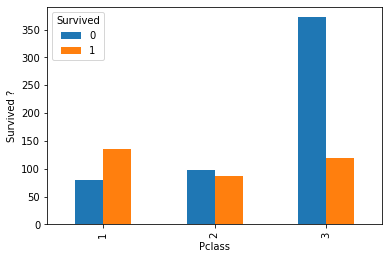

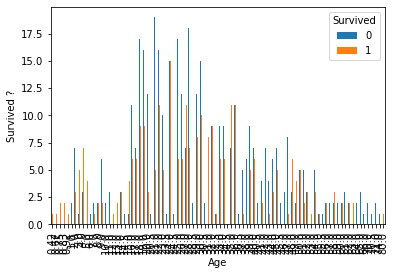

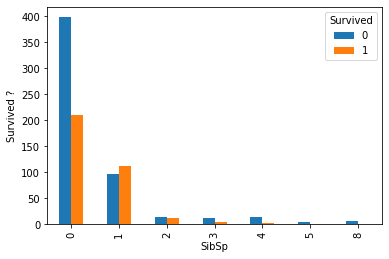

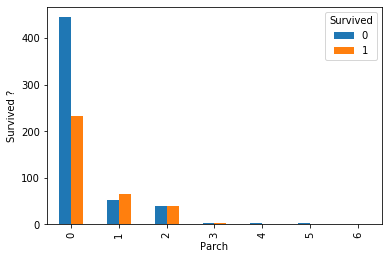

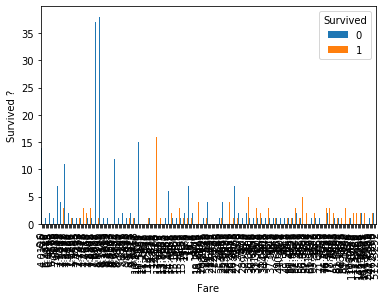

In [0]:
%matplotlib inline

for i in numerical:
  pd.crosstab(train[i],train.Survived).plot(kind='bar')
  plt.xlabel(i)
  plt.ylabel('Survived ?')


In [0]:
train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

##Data Preprocessing & Feature engineering:

Correcting false/missing values:

In [0]:
data=data.drop(columns=['Ticket'])

In [0]:
data.Age=data.Age.fillna(data.Age.mean())
data.Embarked=data.Embarked.fillna("Q")
data.Cabin=data.Cabin.fillna('C')
data.Fare=data.Fare.fillna(33)

data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295254
std,378.020061,0.486592,0.837836,12.883193,1.041658,0.865560,51.738880
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [0]:
Age=data.Age.to_numpy()
for i in range(len(Age)):
  if Age[i]<1:
    Age[i]+=data.Age.mean()
data.Age=Age

In [0]:
cabin=data.Cabin.to_numpy()
for i in range(len(cabin)):
  cabin[i]=cabin[i][0]
data.Cabin=cabin

In [0]:
data.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,C,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,C,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,C,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,C,S
5,6,0.0,3,"Moran, Mr. James",male,29.881138,0,0,8.4583,C,Q
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,51.8625,E,S
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,21.0750,C,S
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,11.1333,C,S
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,30.0708,C,C


In [0]:
titles = set()
for name in data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    data['Title'] = data.Title.map(Title_Dictionary)
#     status('Title')
    return data

data = get_titles()
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,C,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,C,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,C,S,Mr


In [0]:
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.156673
3,Mrs,0.795276
4,Officer,0.277778
5,Royalty,0.600000


In [0]:
#data.Age=pd.cut(data.Age,bins=[0,5,18,30,50,76,100],labels=['Baby','Child','teen','youth','Adult','Elderly'])

In [0]:
#data.Age=np.log(1+data.Age.to_numpy())

In [0]:
#data[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [0]:
data.Pclass=np.asarray([str(ch) for ch in data.Pclass.to_numpy()])

In [0]:
def process_family():
  
    global data
    df=data
    # introducing a new feature : the size of families (including the passenger)
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    # introducing other features based on the family size
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df
data = process_family()

In [0]:
data=data.drop(columns=['Name'])

In [0]:
data1=pd.get_dummies(data)

In [0]:
data1.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0.0,22.0,1,0,7.2500,2,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,2,1.0,38.0,1,0,71.2833,2,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,3,1.0,26.0,0,0,7.9250,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,4,1.0,35.0,1,0,53.1000,2,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,5,0.0,35.0,0,0,8.0500,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [0]:
data1.corr()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,1.000000,-0.005007,0.035518,-0.055224,0.008942,0.031411,-0.031437,0.028546,0.002975,-0.063415,0.026495,0.022714,-0.041544,-0.013406,0.013406,-0.002831,0.015895,0.004604,0.000549,-0.008136,0.000306,-0.045949,-0.023049,0.048101,0.008626,-0.047923,0.002254,-0.050027,0.014116,0.033299,0.002231,-0.016518
Survived,-0.005007,1.000000,-0.048344,-0.035322,0.081629,0.257307,0.016639,-0.203367,0.279855,-0.125147,0.285904,0.093349,-0.322308,0.543351,-0.543351,0.022287,0.175095,-0.283491,0.150716,0.145321,0.057935,0.016040,-0.026456,0.168240,0.013613,-0.155660,0.085221,0.332795,-0.549199,0.344935,-0.031316,0.033391
Age,0.035518,-0.048344,1.000000,-0.188428,-0.108003,0.173857,-0.182971,0.092549,-0.008213,-0.170844,0.363217,-0.008034,-0.307687,-0.059843,0.059843,0.125402,0.111252,-0.190317,0.131985,0.105293,-0.077230,-0.089453,0.032656,0.080401,-0.011728,-0.063364,-0.308524,-0.253120,0.143926,0.193681,0.163906,0.056382
SibSp,-0.055224,-0.035322,-0.188428,1.000000,0.373587,0.160226,0.861952,-0.591077,0.253590,0.699681,-0.034256,-0.052419,0.072610,0.109609,-0.109609,-0.039808,-0.011569,0.045320,-0.015727,-0.027180,-0.008619,0.006015,-0.013247,-0.048396,-0.050818,0.075198,0.329171,0.077564,-0.243104,0.061643,-0.013813,-0.005879
Parch,0.008942,0.081629,-0.108003,0.373587,1.000000,0.221524,0.792296,-0.549022,0.248532,0.624627,-0.013033,-0.010057,0.019521,0.213125,-0.213125,-0.030707,0.073051,-0.035780,-0.027385,0.001084,0.020481,0.058325,-0.012304,-0.008635,-0.102530,0.073258,0.253482,0.066473,-0.304780,0.213491,-0.032631,-0.027555
Fare,0.031411,0.257307,0.173857,0.160226,0.221524,1.000000,0.226468,-0.274829,0.197284,0.170854,0.599958,-0.121370,-0.419620,0.185487,-0.185487,0.020095,0.393744,-0.300386,0.072738,0.073950,-0.037566,-0.022856,0.001179,0.286243,-0.124422,-0.172658,0.011597,0.092053,-0.192196,0.139237,0.028696,0.010602
FamilySize,-0.031437,0.016639,-0.182971,0.861952,0.792296,0.226468,1.000000,-0.688864,0.302640,0.801623,-0.029656,-0.039976,0.058430,0.188583,-0.188583,-0.042967,0.032318,0.010254,-0.025313,-0.017285,0.005525,0.035835,-0.015438,-0.036553,-0.089466,0.089503,0.355061,0.087350,-0.326487,0.157233,-0.026921,-0.018928
Singleton,0.028546,-0.203367,0.092549,-0.591077,-0.549022,-0.274829,-0.688864,1.000000,-0.873398,-0.318944,-0.126551,-0.035075,0.138250,-0.284537,0.284537,0.045227,-0.087912,0.105292,-0.074310,-0.042535,0.004055,-0.076397,0.022411,-0.107874,0.130513,0.011527,-0.265355,-0.023890,0.386262,-0.354649,0.013303,-0.000445
SmallFamily,0.002975,0.279855,-0.008213,0.253590,0.248532,0.197284,0.302640,-0.873398,1.000000,-0.183007,0.165965,0.097270,-0.223338,0.255196,-0.255196,-0.029546,0.084268,-0.143328,0.102432,0.068007,0.012756,0.087471,-0.019574,0.159594,-0.125290,-0.060462,0.120166,-0.018085,-0.300872,0.361247,0.003966,0.008687
LargeFamily,-0.063415,-0.125147,-0.170844,0.699681,0.624627,0.170854,0.801623,-0.318944,-0.183007,1.000000,-0.067523,-0.118495,0.155560,0.077748,-0.077748,-0.033799,0.013470,0.066383,-0.049336,-0.046485,-0.033009,-0.016008,-0.007148,-0.092825,-0.019635,0.094396,0.301809,0.083422,-0.194207,0.012893,-0.034572,-0.016008


In [0]:
Train=data1[0:891]
Test=data1[891:]

In [0]:
Train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0.0,22.0,1,0,7.2500,2,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,2,1.0,38.0,1,0,71.2833,2,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,3,1.0,26.0,0,0,7.9250,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,4,1.0,35.0,1,0,53.1000,2,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,5,0.0,35.0,0,0,8.0500,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(Train, test_size=0.20, random_state=1)
X = train.drop("Survived", axis=1) 
Y = train["Survived"]
X_test = test.drop("Survived", axis=1) 
Y_test = test["Survived"] 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [0]:

reg = LogisticRegression().fit(X,Y)

lr = LinearRegression().fit(X,Y)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1000).fit(X,Y)
from sklearn.neural_network import MLPClassifier
                       
nn=MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(1000, 1),
              learning_rate='constant', learning_rate_init=0.01,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.001,
              validation_fraction=0.1, verbose=False, warm_start=False).fit(X,Y)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =2).fit(X,Y)
xgb_ = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1).fit(X,Y)

lgb_ = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11).fit(X,Y)

rf = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5,n_jobs=-1).fit(X,Y)

In [0]:
y_hat_logR=reg.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_clf = clf.predict(X_test)
y_pred_nn = nn.predict(X_test)
y_pred_GBoost = GBoost.predict(X_test)
y_pred_xgb = xgb_.predict(X_test)
y_pred_lgb = lgb_.predict(X_test)
#y_pred_rf = rf.predict(X_test)



In [0]:
x=0.5
a=pd.DataFrame()
a['y_pred_lr']=y_pred_lr
y_pred_lr=a['y_pred_lr']
y_pred_lr.loc[y_pred_lr > x] = 1
y_pred_lr.loc[y_pred_lr <= x] = 0
'''
a['y_pred_rf']=y_pred_rf
y_pred_rf=a['y_pred_rf']
y_pred_rf.loc[y_pred_rf > x] = 1
y_pred_rf.loc[y_pred_rf <= x] = 0
'''

a['y_pred_xgb']=y_pred_xgb
y_pred_xgb=a['y_pred_xgb']
y_pred_xgb.loc[y_pred_xgb > x] = 1
y_pred_xgb.loc[y_pred_xgb <= x] = 0

a['y_pred_lgb']=y_pred_lgb
y_pred_lgb=a['y_pred_lgb']
y_pred_lgb.loc[y_pred_lgb > x] = 1
y_pred_lgb.loc[y_pred_lgb <= x] = 0

a['y_pred_GBoost']=y_pred_GBoost
y_pred_GBoost=a['y_pred_GBoost']
y_pred_GBoost.loc[y_pred_GBoost > x] = 1
y_pred_GBoost.loc[y_pred_GBoost <= x] = 0




/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
import sklearn
print(sklearn.metrics.classification_report(Y_test , y_hat_logR))
print(sklearn.metrics.classification_report(Y_test , y_pred_lr))
print(sklearn.metrics.classification_report(Y_test , y_pred_clf))
print(sklearn.metrics.classification_report(Y_test , y_pred_nn))
print(sklearn.metrics.classification_report(Y_test , y_pred_xgb))
print(sklearn.metrics.classification_report(Y_test , y_pred_GBoost))
print(sklearn.metrics.classification_report(Y_test , y_pred_lgb))
#print(sklearn.metrics.classification_report(Y_test , y_pred_rf))


              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       106
         1.0       0.76      0.74      0.75        73

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       106
         1.0       0.79      0.74      0.77        73

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179

              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       106
         1.0       0.69      0.64      0.67        73

    accuracy                           0.74       179
   macro avg       0.73      0.72      0.73       179
weighted avg       0.74      0.74      0.74       179

              preci

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##Retraining

In [0]:

X = Train.drop("Survived", axis=1) 
Y = Train["Survived"]

reg = LogisticRegression().fit(X,Y)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
Y_pred=reg.predict(Test.drop("Survived", axis=1) )
Y_pred

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [0]:
submission=pd.read_csv('/content/gender_submission.csv')

In [0]:
Y_pred=Y_pred.astype(int)

submission.Survived=Y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [0]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
